In [8]:
import numpy as np
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

%matplotlib inline

In [9]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [10]:
# Download and load the training data
if not os.path.exists('tmp_dataset'):
    trainset = datasets.MNIST('tmp_dataset/train', download=True, train=True, transform=transform)
    valset = datasets.MNIST('tmp_dataset/val', download=True, train=False, transform=transform)
else:
    trainset = datasets.MNIST('tmp_dataset/train', download=False, train=True, transform=transform)
    valset = datasets.MNIST('tmp_dataset/val', download=False, train=False, transform=transform)

In [11]:
# Create a dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


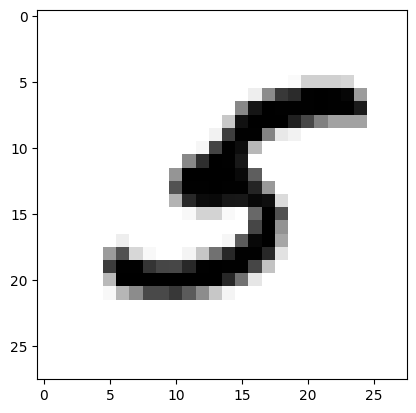

In [12]:
# Obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

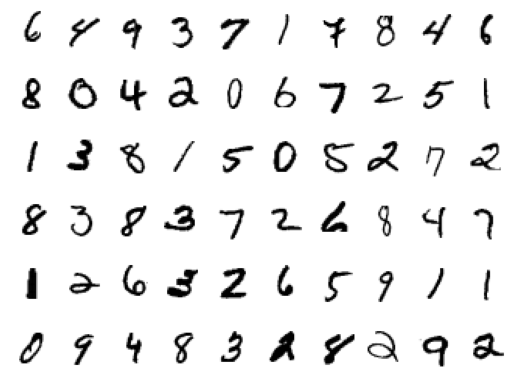

In [13]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [14]:
# define the network architecture
input_size = 784
hidden_sizes = [512, 128]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [20]:
# Define the loss
criterion = nn.NLLLoss()

# get one batch of data
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

# Forward pass, get the logits
logps = model(images) # log probabilities
loss = criterion(logps, labels) # calculate the Negative Log Likelihood (NLL) loss

In [21]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        ...,
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004]])
After backward pass: 
 tensor([[ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]])


In [17]:
# used for collecting the losses for every epoch to display the training progress
vals = []
trains = []

# temp

```python
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
    return last_loss
    ```

In [ ]:
# temp
p = list(model.parameters())



l1 = p[0].detach().numpy()
l1_grad = p[0].detach().numpy()

new_l1 = l1 - l1_grad * 0.1

new_l1 = torch.from_numpy(new_l1)
new_l1.requires_grad = True
new_l1.grad = torch.zeros_like(new_l1)

new_l1

len(p)=6


tensor([[-1.8278e-02, -2.2713e-02,  1.6793e-03,  ...,  3.8052e-03,
         -3.0323e-02, -2.3767e-02],
        [ 2.4589e-02,  1.1588e-02, -1.7523e-02,  ..., -8.9882e-03,
          2.7520e-02,  5.8222e-03],
        [ 7.6841e-03,  3.2013e-02,  2.1775e-02,  ...,  1.6235e-02,
          2.0974e-02, -1.3888e-03],
        ...,
        [-1.8897e-02,  2.3976e-02,  8.5307e-04,  ...,  2.7158e-02,
          2.2674e-02,  3.1168e-02],
        [-5.5268e-04, -1.0994e-02, -1.9141e-02,  ...,  1.4623e-02,
          1.8625e-03,  1.8887e-02],
        [-5.0552e-05,  1.8846e-02,  2.5392e-02,  ...,  1.5298e-02,
         -9.6518e-03, -2.4029e-02]], requires_grad=True)

In [100]:
len(model)
model[0].weight = torch.nn.Parameter(torch.zeros_like(model[0].weight), requires_grad=True)
model[0].weight
# model[0].bias


Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [ ]:
# defining the stochastic gradient descent optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)  # TODO: need to be replaced with self coded optimizer
# set the start time
time0 = time()
epochs = 30


for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # batch training pass
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # This is where the model learns by backpropagating
        # calculate the partial derivatives of the loss function with respect to the weights & biases
        loss.backward()
        
        # optimizes (update) its weights
        # new_parm = old_parm - learning_rate * parm_grad
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        trains.append(running_loss/len(trainloader))
    
    val_loss = 0
    for images, labels in valloader:
        images = images.view(images.shape[0], -1)
        
        # Validation pass
        output = model(images)
        loss = criterion(output, labels)
        
        val_loss += loss.item()
    else:
        print("Epoch {} - Validation loss: {}".format(e, val_loss/len(valloader)))
        vals.append(val_loss/len(valloader))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [ ]:
# oldvals = vals
# oldtrains = trains
 

In [ ]:
# plot the losses
tr = np.array(trains)
vl = np.array(vals)
point_num = -1
plt.plot(tr[:point_num], label='Training loss')
plt.plot(vl[:point_num], label='Validation loss')

plt.plot(oldtrains[:point_num], label='Old Training loss')
plt.plot(oldvals[:point_num], label='Old Validation loss')


plt.legend(frameon=False)

# print the last loss values for training and validation on the plot
# plt.text(point_num, tr[point_num], f'{tr[point_num]:.2f}')
# plt.text(point_num, vl[point_num], f'{vl[point_num]:.2f}')

# save the plot
plt.savefig('loss_plot_new_vs_old.svg')

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

In [ ]:
# torch.save(model, './original_model.pt') 